In [1]:
import numpy as np
import torch
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import ot
import ot.plot
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib.pyplot as pl
import umap
from matplotlib.lines import Line2D

In [2]:
import sys
sys.path.append('../code/')
from HierarchicalOT import load_wmd_data,change_embeddings,reduce_vocab,fit_topics,sparseOT
from sinkhorn_iterates import sinkhorn
from linear_solver import UOT_W
from utils import plot2D_plan,plot2D_plan_vocab

# Illustration on 2 documents

In [3]:
data_path = './data/WordMoverDistances/'
embeddings_path = './data/WordMoverDistances/glove.6B/glove.6B.300d.txt'

# Pick a dataset (n_doc,n_vocab)
data_name = 'bbcsport-emd_tr_te_split.mat' #(737,3657)

idx1=9
idx2=115
idx=[idx1,idx2]
mat_data = loadmat(data_path + data_name, squeeze_me=True, chars_as_strings=True)
y = mat_data['Y'][idx].astype(int)
embeddings_of_doc_words = mat_data['X'][idx]
doc_word_counts = mat_data['BOW_X'][idx]
doc_words = mat_data['words'][idx]
vocab = []
embed_vocab = {}
for d_w, d_e in zip(doc_words, embeddings_of_doc_words):
    if type(d_w) == str:
        d_w = [d_w]
    words = [w for w in d_w if type(w) == str]
    if len(words) == 1:
        d_e = d_e.reshape((-1, 1))
    for i, w in enumerate(words):
        if w not in vocab:
            vocab.append(w)
            embed_vocab[w] = d_e[:, i]
        else:
            if not np.allclose(embed_vocab[w], d_e[:, i]):
                print('Problem with embeddings')
                break

bow_data = np.zeros((len(doc_word_counts), len(vocab)),
                        dtype=int)
for doc_idx, (d_w, d_c) in enumerate(zip(doc_words, doc_word_counts)):
    if type(d_w) == str:
        d_w = [d_w]
    words = [w for w in d_w if type(w) == str]
    if len(words) == 1:
        d_c = np.array([d_c])
    words_idx = np.array([vocab.index(w) for w in words])
    bow_data[doc_idx, words_idx] = d_c.astype(int)

# if glove = True
# embed in Glove
vocab, embed_vocab, bow_data = change_embeddings(vocab, bow_data, embeddings_path)

# Reduce vocabulary by removing short words, stop words, and stemming (root words?)
vocab, embed_vocab, bow_data = reduce_vocab(bow_data, vocab, embed_vocab, embed_aggregate='mean')

# Matrix of word embeddings: nb_vocab x 300
embeddings = np.array([embed_vocab[w] for w in vocab])

#cost_embeddings cost matrix nb_vocabs x nb_vocabs (on R^300)
cost_embeddings = euclidean_distances(embeddings, embeddings) ** 2

print(bow_data.shape)
print(vocab)

(2, 22)
['collin', 'compet', 'birmingham', 'world', 'champion', 'olymp', 'franci', 'indoor', 'said', 'good', 'home', 'win', 'match', 'zealand', 'open', 'game', 'michael', 'seri', 'batsman', 'marshal', 'captain', 'play']


In [4]:
a=np.copy(bow_data[0])
b=np.copy(bow_data[1])
a=a/(a.sum())
b=b/(b.sum())

In [5]:
### Embeddings ###
n=cost_embeddings.shape[0]-1
np.random.seed(0)
low_embeddings = PCA(n_components=min(len(vocab),50)).fit_transform(embeddings)
low_vocab = manifold.TSNE(n_components=2, learning_rate='auto',
                               init='random', perplexity=3,early_exaggeration=50.0).fit_transform(low_embeddings)
low_vocab.shape

(22, 2)

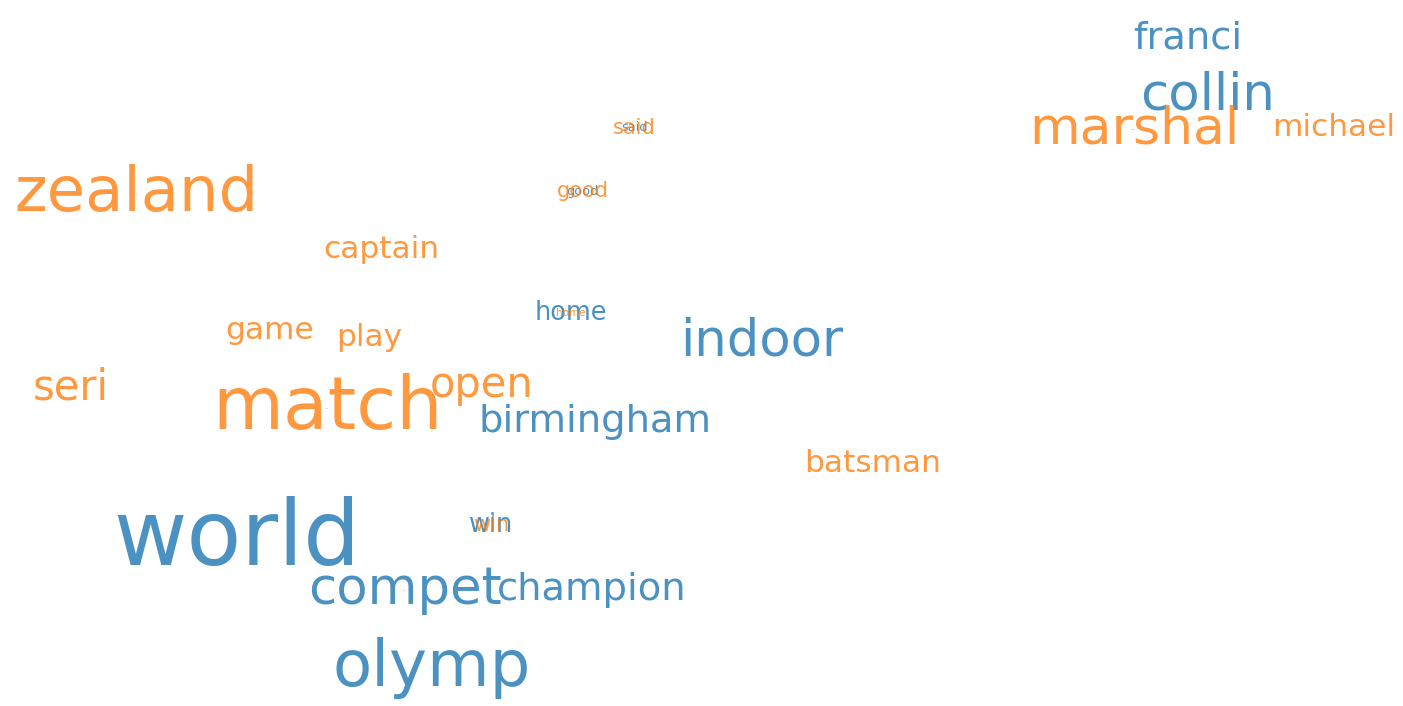

In [6]:
s=500
fig, ax = pl.subplots(figsize=(20,10))
pl.scatter(low_vocab[:,0], low_vocab[:,1],alpha=0)
for i in range(len(vocab)):
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a[i],c="C0",alpha=.8,ha="center",va="center",transform=ax.transData)
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b[i],c="C1",alpha=.8,ha="center",va="center",transform=ax.transData)
pl.axis('off')
pl.tight_layout()
#pl.savefig("../Figures/vocab.pdf",bbox_inches='tight')

In [7]:
### Map embedding ###

a1 = a[np.where(a)[0]]
b1 = b[np.where(b)[0]]
C = np.ascontiguousarray(cost_embeddings[np.where(a)[0]][:,np.where(b)[0]])
X=low_vocab[np.where(a)[0]]
Y=low_vocab[np.where(b)[0]]

Pwmd=ot.emd(a1,b1,C)

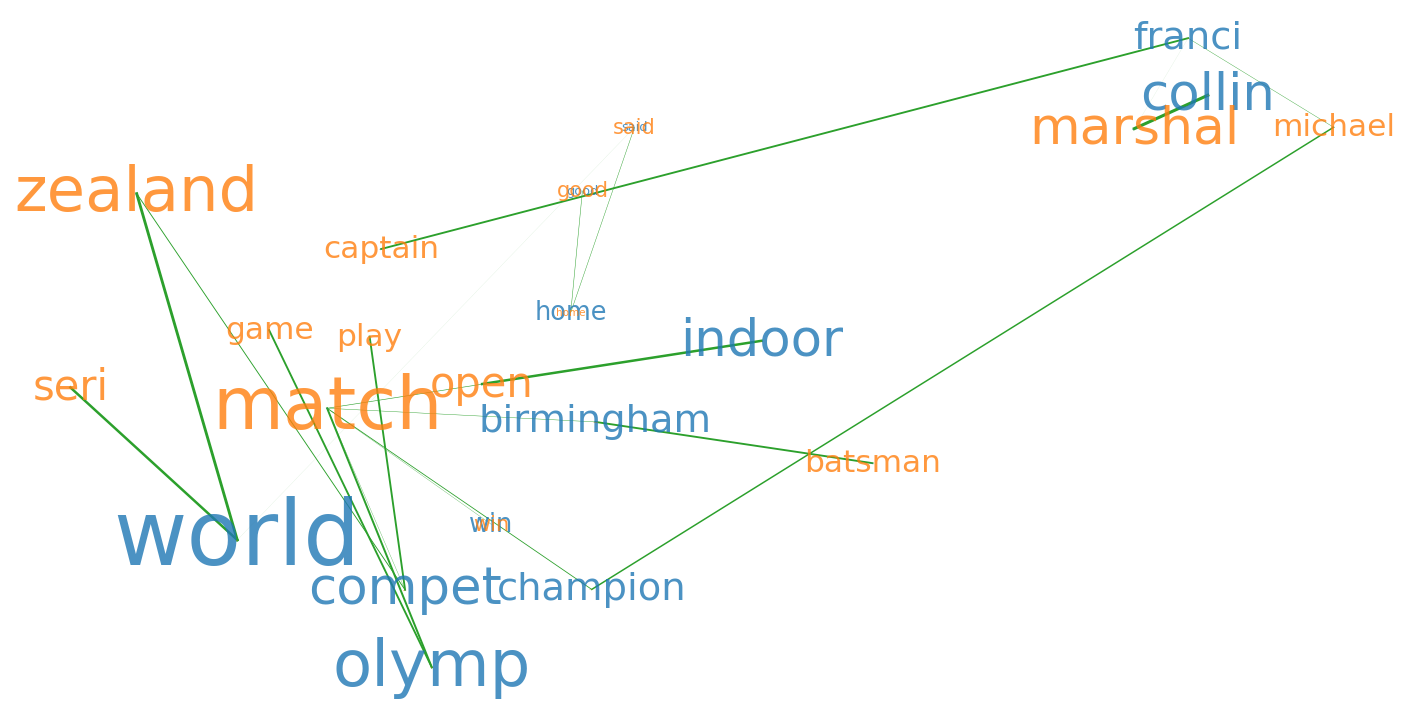

In [8]:
s=500
fig, ax = pl.subplots(figsize=(20,10))
pl.scatter(low_vocab[:,0], low_vocab[:,1],alpha=0)
plot2D_plan_vocab(X, Y, Pwmd, c="C2",ssize=30)
for i in range(len(vocab)):
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a[i],c="C0",alpha=.8,ha="center",va="center",transform=ax.transData)
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b[i],c="C1",alpha=.8,ha="center",va="center",transform=ax.transData)
pl.axis('off')
pl.tight_layout()
#pl.savefig("../Figures/WMD.pdf",bbox_inches='tight')

In [9]:
### UOT Embedding ###
Cx = np.ascontiguousarray(cost_embeddings[np.where(a)[0]][:,np.where(a)[0]])
Cy = np.ascontiguousarray(cost_embeddings[np.where(b)[0]][:,np.where(b)[0]])
Puot,Qx,Qy=UOT_W(a1,b1,C,lam=.55,Cx=Cx,Cy=Cy,innerplan=True)

a2=np.zeros(a.shape)
a2[np.where(a)[0]]=np.sum(Puot,axis=1)
b2=np.zeros(b.shape)
b2[np.where(b)[0]]=np.sum(Puot,axis=0)

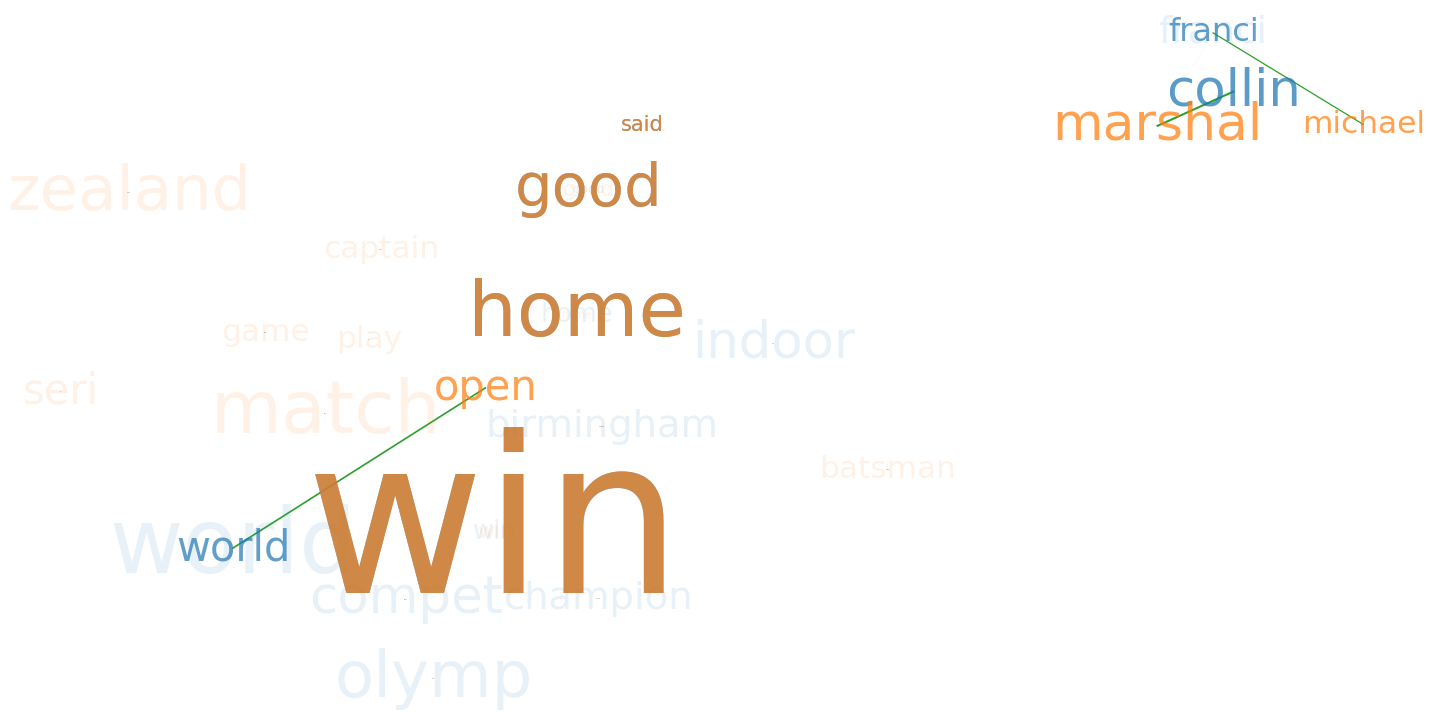

In [11]:
pl.figure(figsize=(20,10))
plot2D_plan_vocab(X, Y, Puot, c="C2",ssize=20)
for i in range(len(vocab)):
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a[i],c="C0",alpha=.1,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b[i],c="C1",alpha=.1,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a2[i],c="C0",alpha=.7,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b2[i],c="C1",alpha=.7,ha="center",va="center")
pl.axis('off')
pl.tight_layout()
pl.savefig("../Figures/UOTW1.pdf",bbox_inches='tight')

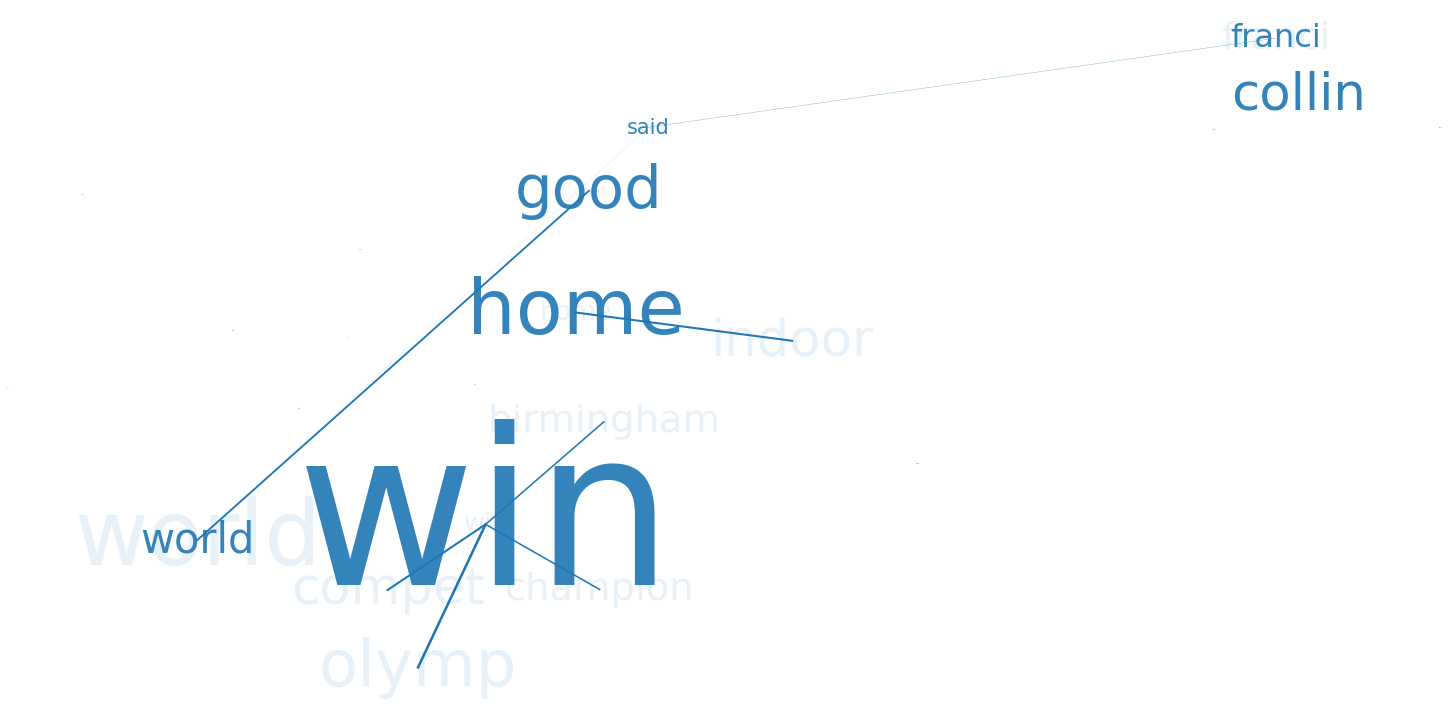

In [17]:
# Source to source
pl.figure(figsize=(20,10))
plot2D_plan_vocab(X, X, Qx, c="C0",ssize=20)
#plot2D_plan_vocab(Y, Y, Qy, c="C1",ssize=100)
for i in range(len(vocab)):
    pl.text(low_vocab[i,0],low_vocab[i,1], vocab[i], fontsize = s*a[i],c="C0",alpha=.1,ha="center",va="center")
    #pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b[i],c="C1",alpha=.2,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a2[i],c="C0",alpha=.9,ha="center",va="center")
    #pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b2[i],c="C1",alpha=.9,ha="center",va="center")
pl.axis('off')
pl.tight_layout()
#pl.savefig("../Figures/UOTW2.pdf",bbox_inches='tight')

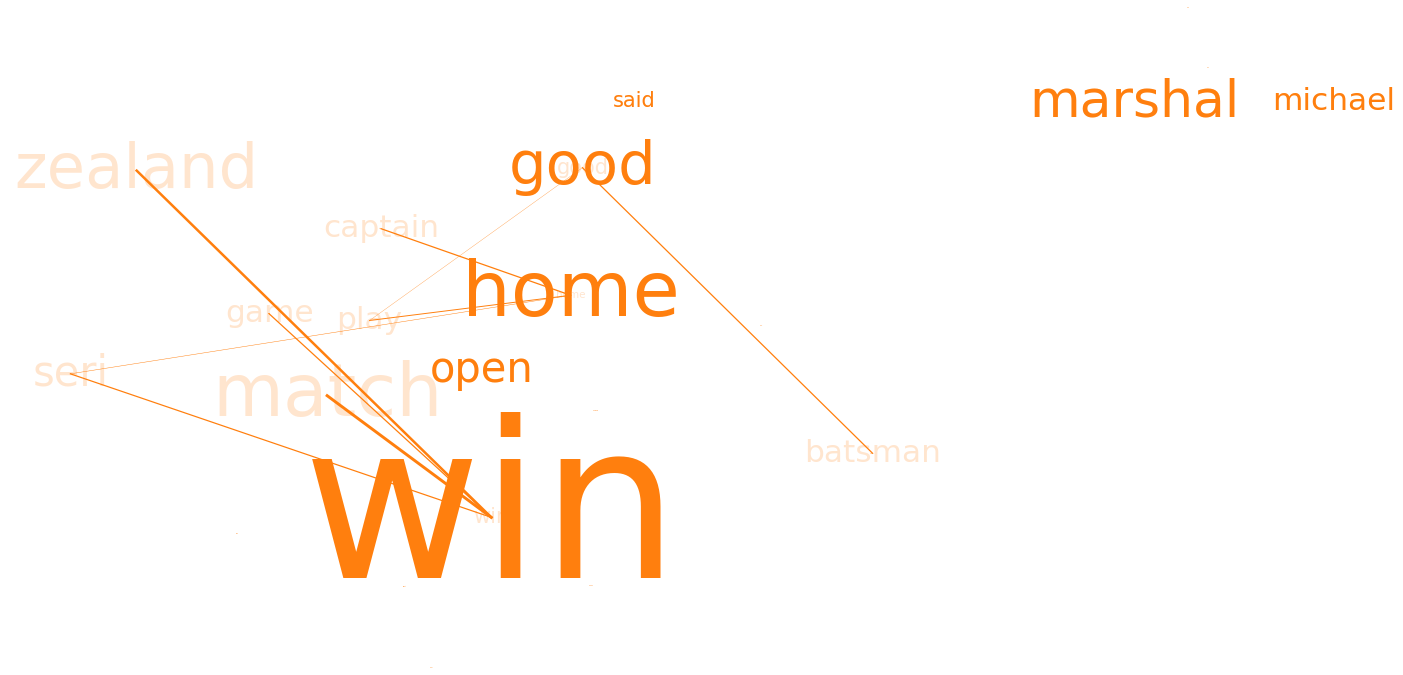

In [18]:
### Target to target ###
pl.figure(figsize=(20,10))
#plot2D_plan_vocab(X, X, Qx, c="C0",ssize=100)
plot2D_plan_vocab(Y, Y, Qy, c="C1",ssize=20)
for i in range(len(vocab)):
    #pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*a[i],c="C0",alpha=.1,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b[i],c="C1",alpha=.2,ha="center",va="center")
    #pl.text(low_vocab[i,0],low_vocab[i,1], vocab[i], fontsize = s*a2[i],c="C0",alpha=.9,ha="center",va="center")
    pl.text(low_vocab[i,0], low_vocab[i,1], vocab[i], fontsize = s*b2[i],c="C1",alpha=1,ha="center",va="center")
pl.axis('off')
pl.tight_layout()
#pl.savefig("../Figures/UOTW3.pdf",bbox_inches='tight')